In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import black
# Uncomment and run this before releasing a new version of the docs
# import jupyter_black

# jupyter_black.load(
#     lab=False,
#     line_length=100,
#     verbosity="DEBUG",
#     target_version=black.TargetVersion.PY310,
# )

import copy
import glob
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.modeling import models

from stingray.gti import create_gti_from_condition, gti_border_bins, time_intervals_from_gtis, cross_two_gtis
from stingray.utils import show_progress
from stingray.fourier import avg_cs_from_events, avg_pds_from_events, poisson_level, get_average_ctrate
from stingray import AveragedPowerspectrum, AveragedCrossspectrum, EventList, Lightcurve, Powerspectrum
from stingray.modeling.parameterestimation import PSDLogLikelihood

## Data loading and cleanup

In [2]:
filename = "P061433800303_LE_screen.fits"

In [3]:
from astropy.io import fits
# Open the FITS file
with fits.open(filename) as hdul:
    # Get the primary HDU (Header Data Unit)
    header = hdul[1].header

    # Print the header
    print(repr(header))

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   22 / width of table in bytes                        
NAXIS2  =             19772082 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    9 / number of fields in each row                   
TTYPE1  = 'Time    '           / Event arrival time                             
TFORM1  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT1  = 's       '           / physical unit of field                         
TTYPE2  = 'Det_ID  '           / Detector id (0-95)                             
TFORM2  = '1B      '        

In [4]:
events = EventList.read(filename, "hea")
events.fname = filename

/Users/songyj/anaconda3/lib/python3.11/site-packages/stingray/io.py:579: UserWarning: HDU EVENTS not found. Trying first extension
  warnings.warn(f"HDU {hduname} not found. Trying first extension")
Error: list index out of range
GTIs will be set to the entire time series. [stingray.io]


array([[3.67945493e+08, 3.67952513e+08]], dtype=float64)

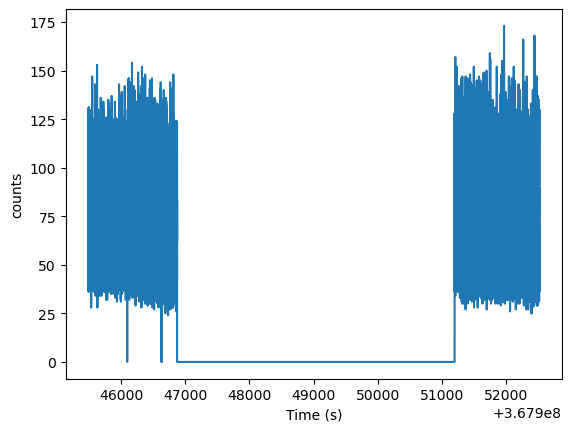

In [5]:
lc_raw = events.to_lc(dt=0.01)
lc_raw.plot()
lc_raw.check_lightcurve()
lc_raw.gti

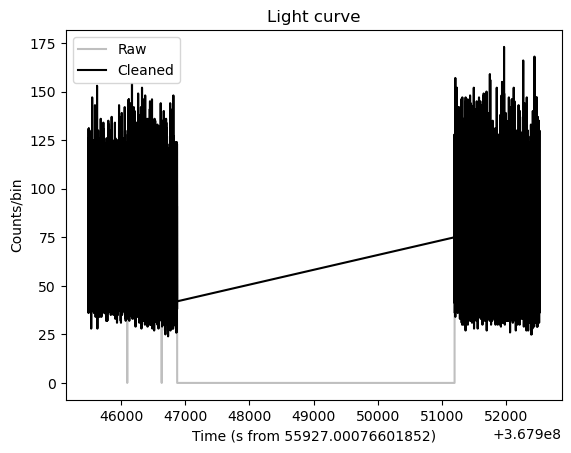

In [6]:
new_gti = create_gti_from_condition(lc_raw.time, lc_raw.counts > 0, safe_interval=0)
lc = copy.deepcopy(lc_raw)
lc.gti = new_gti
lc.apply_gtis()

plt.figure()
plt.plot(lc_raw.time, lc_raw.counts, color="grey", alpha=0.5, label="Raw")
plt.plot(lc.time, lc.counts, color="k", label="Cleaned")
plt.title("Light curve")
plt.xlabel(f"Time (s from {events.mjdref})")
plt.ylabel(f"Counts/bin")
plt.legend();

events.gti = new_gti

<Axes: xlabel='Time (s)', ylabel='counts'>

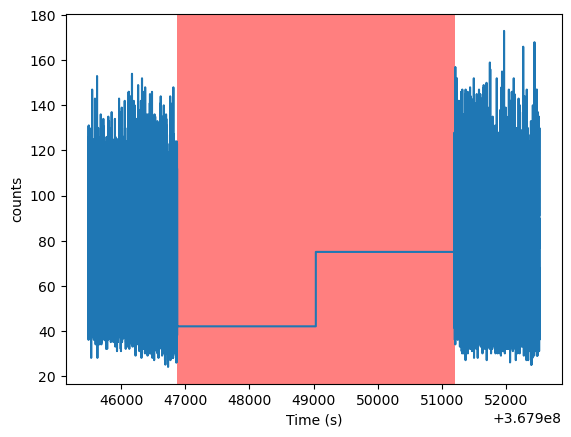

In [7]:
lc.plot()
# plt.xlim((3.839e8+13500,3.839e8+14000))

Total exposure: 2698.0
Total BTI length: 4322.0
Total BTI length (short BTIs): 0.0


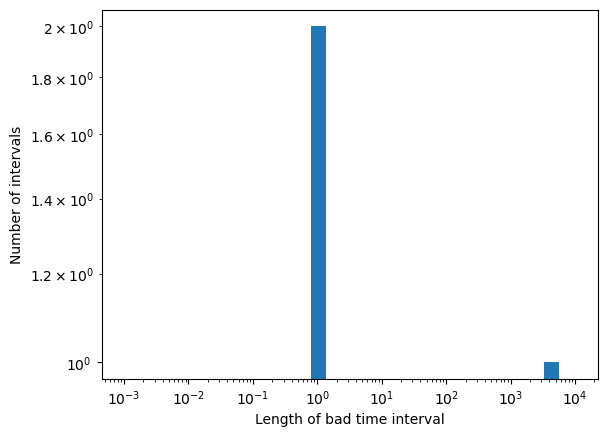

In [8]:
#让我们对这些不良时间间隔（尤其是非常小的时间间隔）进行一些统计。

from stingray.gti import get_gti_lengths, get_btis, get_total_gti_length

gti_lengths = get_gti_lengths(events.gti)
btis = get_btis(events.gti)
bti_lengths = get_gti_lengths(btis)

plt.hist(bti_lengths, bins=np.geomspace(1e-3, 10000, 30))
plt.xlabel("Length of bad time interval")
plt.ylabel("Number of intervals")
plt.loglog()

print(f"Total exposure: {get_total_gti_length(events.gti)}")
print(f"Total BTI length: {get_total_gti_length(btis)}")
print(f"Total BTI length (short BTIs): {get_total_gti_length(btis[bti_lengths < 1])}")

<Axes: xlabel='Time (s)', ylabel='counts'>

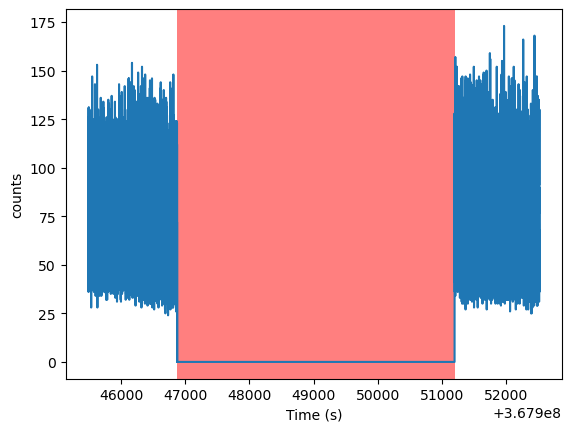

In [9]:
# max_length is the longest bad time interval in seconds we want to fill with simulated data.
# The buffer size is the region (in seconds) around the bad time interval that we use to
# extract the distribution of the data to simulate
ev_filled = events.fill_bad_time_intervals(max_length=1, buffer_size=4)
lc_filled = ev_filled.to_lc(dt=0.01)
# lc_filled.plot(axis_limits=[1.331126e8, 1.331134e8, None, None])
lc_filled.plot()

In [10]:
lc1 = ev_filled.to_lc(dt=1)
lc1.time

array([3.67945494e+08, 3.67945494e+08, 3.67945496e+08, ...,
       3.67952510e+08, 3.67952512e+08, 3.67952512e+08])

<Axes: xlabel='Time (s)', ylabel='counts'>

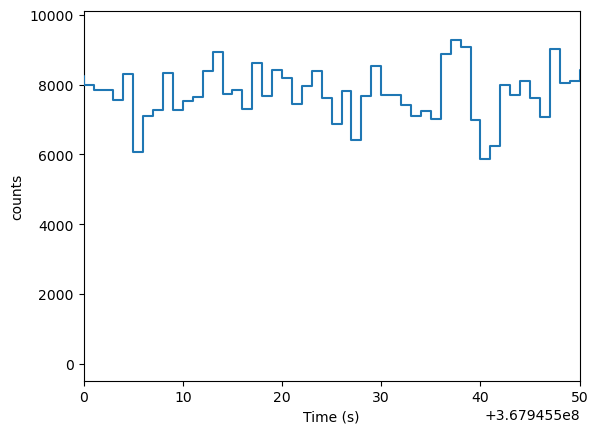

In [11]:
lc1.plot(axis_limits=[3.6794e8+5500, 3.6794e8+5550, None, None])

## 从events 提取pds

In [12]:
# Calculate the periodogram in fractional rms normalization.
# Length in seconds of each light curve segment
segment_size = 256
# Sampling time of the light curve: 1ms, this will give a Nyquist
# frequency of 0.5 / dt = 500 Hz.  
# 采样频率是1/dt=1000Hz 奈奎斯特频率是采样频率的一半:500Hz,也是光曲线中可以测量的最高频率.
dt=0.001
norm = "leahy"

pds = AveragedPowerspectrum.from_events(
    ev_filled, segment_size=segment_size, dt=dt, norm=norm, use_common_mean=True
)
# Calculate the mean count rate 平均计数率
ctrate = get_average_ctrate(ev_filled.time, ev_filled.gti, segment_size)
# 计算泊松噪声
noise = poisson_level(norm, meanrate=ctrate)

pds_reb = pds.rebin_log(0.02)

10it [00:00, 38.95it/s]


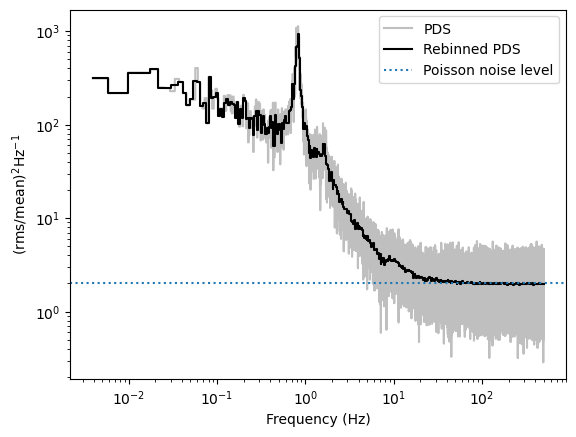

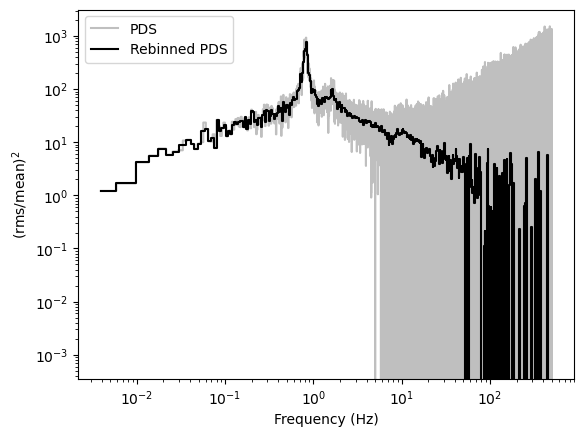

In [13]:
plt.figure()

plt.plot(pds.freq, pds.power, drawstyle="steps-mid", color="grey", alpha=0.5, label="PDS")
plt.plot(pds_reb.freq, pds_reb.power, drawstyle="steps-mid", color="k", label="Rebinned PDS")
plt.axhline(noise, ls=":", label="Poisson noise level")
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2 Hz^{-1}}$")
plt.legend()

plt.figure()
plt.plot(
    pds.freq,
    (pds.power - noise) * pds.freq,
    drawstyle="steps-mid",
    color="grey",
    alpha=0.5,
    label="PDS",
)
plt.plot(
    pds_reb.freq,
    (pds_reb.power - noise) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$")
plt.legend();

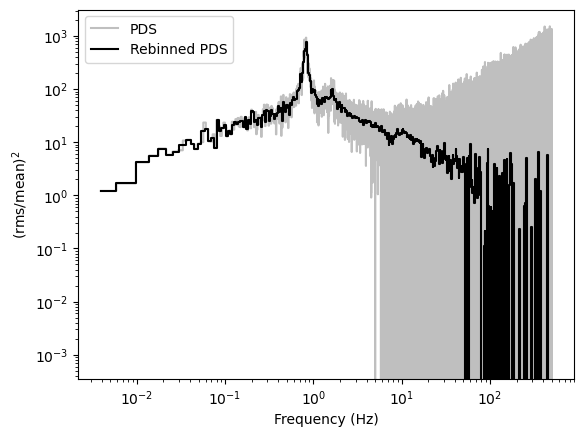

In [14]:
plt.figure()
plt.plot(
    pds.freq,
    (pds.power - noise) * pds.freq,
    drawstyle="steps-mid",
    color="grey",
    alpha=0.5,
    label="PDS",
)
plt.plot(
    pds_reb.freq,
    (pds_reb.power - noise) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$")
plt.legend();

## 从light curve提取pds

In [15]:
segment_size = 256
dt=0.01
norm = "leahy"

pds = AveragedPowerspectrum.from_lightcurve(
    lc_filled, segment_size=segment_size, norm=norm, use_common_mean=True
)

ctrate = get_average_ctrate(lc_filled.time, lc_filled.gti, segment_size)
noise = poisson_level(norm, meanrate=ctrate)

pds_reb = pds.rebin_log(0.02)

0it [00:00, ?it/s]

10it [00:00, 2541.39it/s]


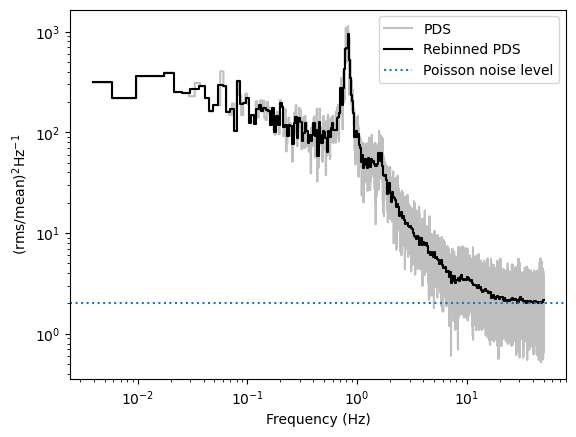

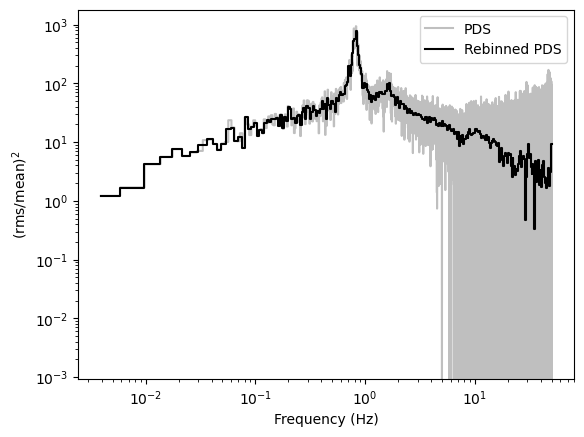

In [16]:
plt.figure()

plt.plot(pds.freq, pds.power, drawstyle="steps-mid", color="grey", alpha=0.5, label="PDS")
plt.plot(pds_reb.freq, pds_reb.power, drawstyle="steps-mid", color="k", label="Rebinned PDS")
plt.axhline(noise, ls=":", label="Poisson noise level")
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2 Hz^{-1}}$")
plt.legend()

plt.figure()
plt.plot(
    pds.freq,
    (pds.power - noise) * pds.freq,
    drawstyle="steps-mid",
    color="grey",
    alpha=0.5,
    label="PDS",
)
plt.plot(
    pds_reb.freq,
    (pds_reb.power - noise) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$")
plt.legend();

## 绘制交叉谱

In [17]:
# 在这种情况下，无需减去泊松噪声水平，因为只要能带不重叠，泊松噪声水平在交叉谱中为零。
dt=0.001
ref_band = [579, 1170]
sub_band = [225, 461]
ref_b = [5,10]
sub_b = [2,4]
events_ref = ev_filled.filter_energy_range(ref_band, use_pi=True)
events_sub = ev_filled.filter_energy_range(sub_band, use_pi=True)

cs = AveragedCrossspectrum.from_events(
    events_sub, events_ref, segment_size=segment_size, dt=dt, norm=norm
)
cs_reb = cs.rebin_log(0.02)

10it [00:00, 85.98it/s]
/Users/songyj/anaconda3/lib/python3.11/site-packages/stingray/fourier.py:1125: UserWarning: n_ave is below 30. Please note that the error bars on the quantities derived from the cross spectrum are only reliable for a large number of averaged powers.
  warnings.warn(
/Users/songyj/anaconda3/lib/python3.11/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/Users/songyj/anaconda3/lib/python3.11/site-packages/stingray/fourier.py:1141: RuntimeWarning: invalid value encountered in sqrt
  dphi = np.sqrt(
/Users/songyj/anaconda3/lib/python3.11/site-packages/stingray/crossspectrum.py:2991: UserWarning: Some error bars in the Averaged Crossspectrum are invalid.Defaulting to sqrt(2 / M) in Leahy norm, rescaled to the appropriate norm.
  warnings.warn(


/Users/songyj/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


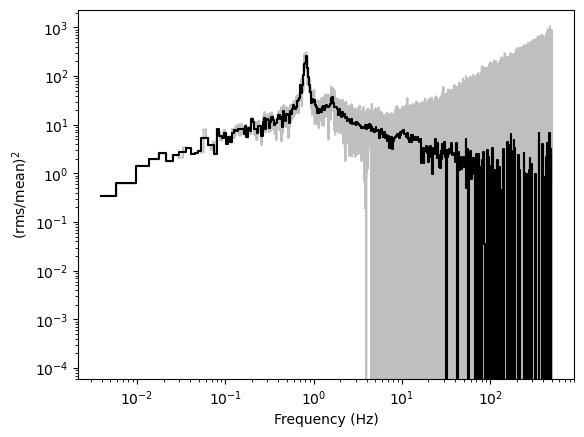

In [18]:
plt.figure()
plt.plot(cs.freq, cs.power * cs.freq, drawstyle="steps-mid", color="grey", alpha=0.5)
plt.plot(cs_reb.freq, cs_reb.power * cs_reb.freq, drawstyle="steps-mid", color="k")
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$");

## 周期图建模

(0.0, 817.017091911507)

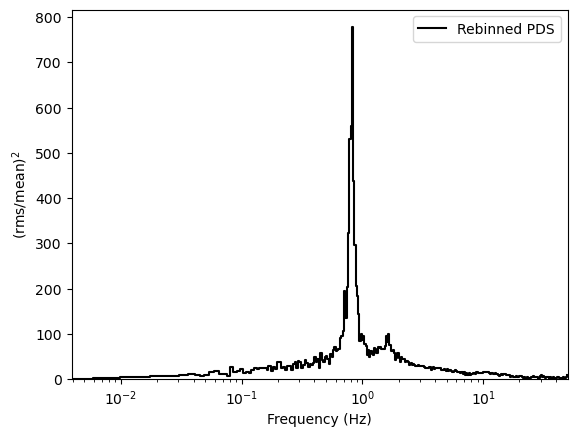

In [19]:
plt.plot(
    pds_reb.freq,
    (pds_reb.power - 2) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)
plt.semilogx()
plt.xlim([pds.freq[0], pds.freq[-1]])
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$")
plt.legend()
plt.ylim([0, None])

In [168]:
fit_model = (
    models.Lorentz1D(x_0=0.8, fwhm=0.15, amplitude=1000)
    + models.Lorentz1D(x_0=1.6, fwhm=0.1, amplitude=60)
    + models.Lorentz1D(x_0=10, fwhm=1, amplitude=3)
    + models.Lorentz1D(x_0=0.1, fwhm=0.1, amplitude=300)
    + models.Lorentz1D(x_0=1, fwhm=1, amplitude=200)
)

(0.0, 989.7240066008039)

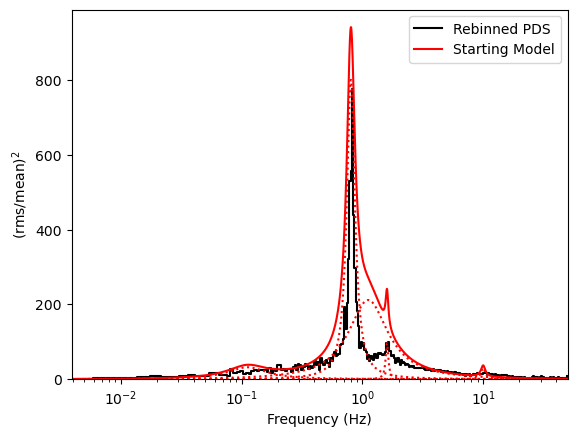

In [170]:
plt.figure()
plt.plot(
    pds_reb.freq,
    (pds_reb.power - 2) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)
plt.plot(pds.freq, fit_model(pds.freq) * pds.freq, color="r", label="Starting Model")
for mod in fit_model:
    plt.plot(pds.freq, mod(pds.freq) * pds.freq, color="r", ls=":")

plt.semilogx()
plt.xlim([pds.freq[0], pds.freq[-1]])
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$")
plt.legend()
plt.ylim([0, None])

In [171]:
# 现在，我们将在泊松噪声水平（Leahy 标准化中为 2）添加一个常数，并使用最大似然估计进行拟合
from stingray.modeling import PSDParEst

fit_model = models.Const1D(amplitude=2) + fit_model

parest = PSDParEst(pds_reb, fitmethod="L-BFGS-B", max_post=False)
loglike = PSDLogLikelihood(pds_reb.freq, pds_reb.power, fit_model, m=pds_reb.m)

res = parest.fit(loglike, fit_model.parameters)

fitmod = res.model

# The Poisson noise level was the first parameter.
poisson = fitmod.parameters[0]
print(res.p_opt)

[ 2.00944332e+00  9.96226554e+02  8.15041863e-01  7.55713025e-02
  2.59380386e+01  1.58857979e+00 -4.63480524e-01  5.01408210e-01
  1.07998940e+01  3.36869473e+00  2.98777579e+02 -3.85344212e-02
  1.19633757e-01  1.97522679e+02 -4.51928575e-01  1.47305011e+00]


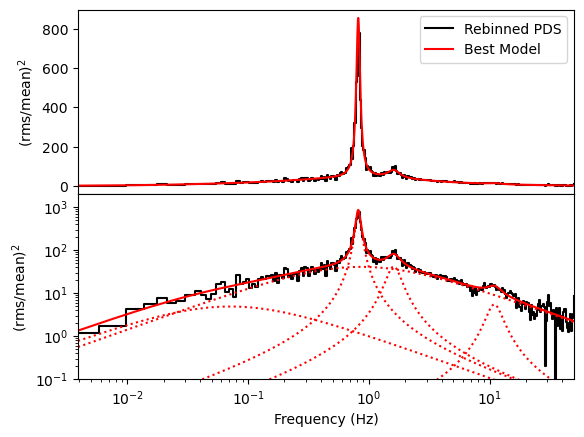

In [172]:
plt.figure()
gs = plt.GridSpec(2, 1, hspace=0)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

ax0.plot(
    pds_reb.freq,
    (pds_reb.power - poisson) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)
ax0.plot(pds.freq, (fitmod(pds.freq) - poisson) * pds.freq, color="r", label="Best Model")
# for mod in fitmod[1:]:
#     ax0.plot(pds.freq, mod(pds.freq) * pds.freq, color="r", ls=":")

ax0.set_xlabel("Frequency (Hz)")
ax0.set_ylabel(r"$\mathrm{(rms / mean)^2}$")
ax0.legend()

ax1.plot(
    pds_reb.freq,
    (pds_reb.power - poisson) * pds_reb.freq,
    drawstyle="steps-mid",
    color="k",
    label="Rebinned PDS",
)
ax1.plot(pds.freq, (fitmod(pds.freq) - poisson) * pds.freq, color="r", label="Best Model")
for mod in fitmod[1:]:
    ax1.plot(pds.freq, mod(pds.freq) * pds.freq, color="r", ls=":")

ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel(r"$\mathrm{(rms / mean)^2}$")
ax1.loglog()
ax1.set_ylim([1e-1, None])
ax1.set_xlim([pds.freq[0], pds.freq[-1]]);

## power color

In [24]:
from stingray import DynamicalPowerspectrum
from stingray.power_colors import hue_from_power_color, plot_power_colors, plot_hues, DEFAULT_COLOR_CONFIGURATION, power_color

In [25]:
# We use a segment size of 256, corresponding to a minimum frequency of 0.00390625, and a time resolution
# of 1/256 = 0.00390625 seconds, corresponding to a Nyquist frequency of 128 Hz (well above our needs for
# the power colors).

dynps = DynamicalPowerspectrum(ev_filled, segment_size=256, sample_time=1 / 256, norm="leahy")

0it [00:00, ?it/s]

10it [00:00, 80.28it/s]


In [26]:
dynps_reb = dynps.rebin_by_n_intervals(2, method="average")

In [27]:
p1, p1e, p2, p2e = dynps_reb.power_colors(
    freq_edges=[1 / 256, 1 / 32, 0.25, 2, 16], poisson_power=res.p_opt[0]
)

hues = hue_from_power_color(p1, p2)

In [28]:
rms, rmse = dynps_reb.compute_rms(1 / 64, 16, poisson_noise_level=res.p_opt[0])

/Users/songyj/anaconda3/lib/python3.11/site-packages/stingray/fourier.py:884: UserWarning: All power spectral bins have M<30. The error bars on the rms might be wrong. In some cases one might try to increase the number of segments, for example by reducing the segment size, in order to obtain at least 30 segments.
  warnings.warn(


In [29]:
configuration=DEFAULT_COLOR_CONFIGURATION
configuration

{'center': [4.5192, 0.453724],
 'ref_angle': 2.356194490192345,
 'state_definitions': {'HSS': {'hue_limits': [300, 360], 'color': 'red'},
  'LHS': {'hue_limits': [-20, 140], 'color': 'blue'},
  'HIMS': {'hue_limits': [140, 220], 'color': 'green'},
  'SIMS': {'hue_limits': [220, 300], 'color': 'yellow'}},
 'rms_spans': {-20: [0.3, 0.7],
  0: [0.3, 0.7],
  10: [0.3, 0.6],
  40: [0.25, 0.4],
  100: [0.25, 0.35],
  150: [0.2, 0.3],
  170: [0.0, 0.3],
  200: [0, 0.15],
  370: [0, 0.15]}}

<Axes: xlabel='log$_{10}$PC1', ylabel='log$_{10}$PC2'>

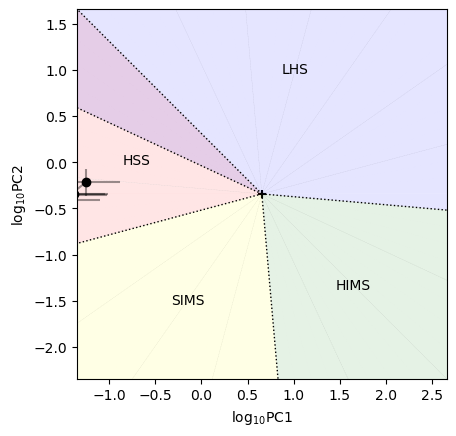

In [30]:
plot_power_colors(p1, p1e, p2, p2e, plot_spans=True, configuration=configuration)

<Axes: xlabel='Hue', ylabel='Fractional rms'>

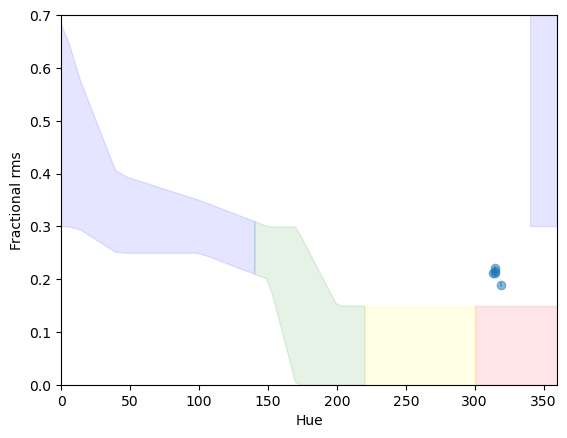

In [31]:
# We can plot the rms versus the hue, and it is immediately clear that the rms is far too high for a soft state. 
# 区分上图HSS和LHS共有的紫色区域
plot_hues(rms, rmse, p1, p2, plot_spans=True, configuration=configuration)

<PolarAxes: >

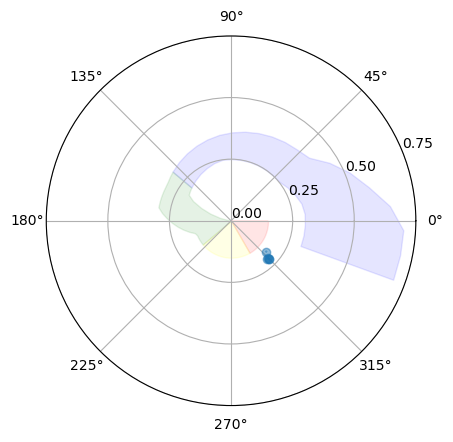

In [32]:
# 半径是均方根，色调是角度
plot_hues(rms, rmse, p1, p2, polar=True, plot_spans=True, configuration=configuration)

## lags and coherence

In [33]:
# Use shorter segments, rebin a little more heavily
cs = AveragedCrossspectrum.from_events(events_sub, events_ref, segment_size=2, dt=0.005, norm=norm)
cs_reb = cs.rebin_log(0.4)

lag, lag_e = cs_reb.time_lag()

0it [00:00, ?it/s]

1350it [00:00, 14570.98it/s]
/Users/songyj/anaconda3/lib/python3.11/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/Users/songyj/anaconda3/lib/python3.11/site-packages/stingray/fourier.py:1141: RuntimeWarning: invalid value encountered in sqrt
  dphi = np.sqrt(
/Users/songyj/anaconda3/lib/python3.11/site-packages/stingray/crossspectrum.py:2991: UserWarning: Some error bars in the Averaged Crossspectrum are invalid.Defaulting to sqrt(2 / M) in Leahy norm, rescaled to the appropriate norm.
  warnings.warn(


[]

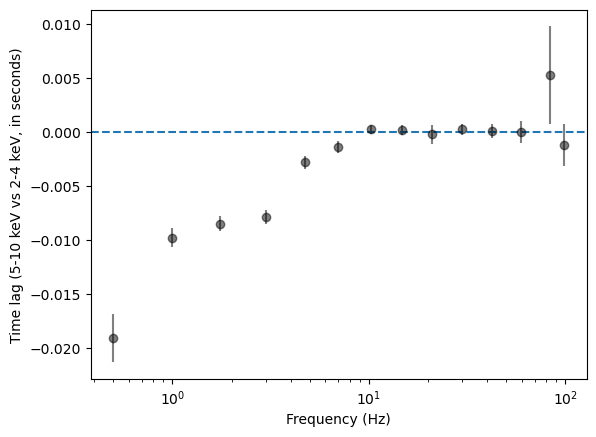

In [34]:
plt.figure()
plt.errorbar(cs_reb.freq, lag, yerr=lag_e, fmt="o", color="k", alpha=0.5)
plt.xlabel("Frequency (Hz)")
plt.ylabel(
    f"Time lag ({ref_b[0]:g}-{ref_b[1]:g} keV vs {sub_b[0]:g}-{sub_b[1]:g} keV, in seconds)"
)
plt.axhline(0, ls="--")
plt.semilogx()

[]

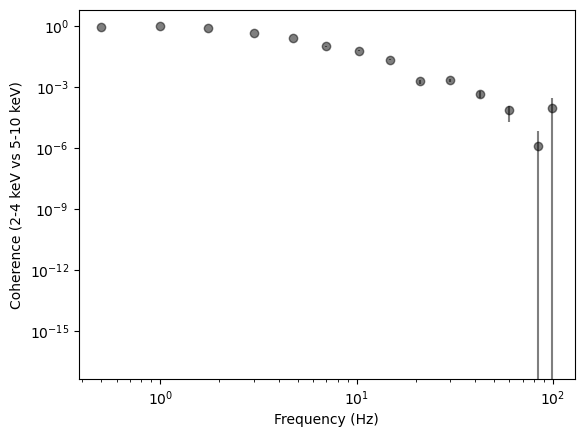

In [35]:
# 不同频率下的相干性
coh, coh_e = cs_reb.coherence()
plt.figure()
plt.errorbar(cs_reb.freq, coh, yerr=coh_e, fmt="o", color="k", alpha=0.5)
plt.xlabel("Frequency (Hz)")
plt.ylabel(
    f"Coherence ({sub_b[0]:g}-{sub_b[1]:g} keV vs {ref_b[0]:g}-{ref_b[1]:g} keV)"
)
plt.axhline(0, ls="--")
plt.loglog()

## spectral timing

In [36]:
from stingray.varenergyspectrum import CountSpectrum, CovarianceSpectrum, RmsSpectrum, LagSpectrum

In [37]:
def pi_to_energy(pi_values):
    # 这是一个示例，假设能量和 PI 有线性关系
    energy = 13*pi_values/1536+0.1
    return energy

In [38]:
pi_values = ev_filled.pi
energy_values = pi_to_energy(pi_values)
print(pi_values)
print(energy_values)
print(len(pi_values))
print(len(energy_values))

has_nan = np.isnan(energy_values).any()
print(f"Does the list contain NaN values? {has_nan}")

[ 187.  129.  117. ...  848. 1023.  168.]
[1.6826823 1.1917969 1.0902344 ... 7.2770834 8.7582035 1.521875 ]
19786326
19786326
Does the list contain NaN values? False


In [39]:
ev_filled.energy = energy_values
# 检查并打印能量值
print(len(ev_filled.energy))
print(len(ev_filled.time))
print(len(ev_filled.pi))


19786326
19786326
19786326


In [40]:

energy_spec = np.geomspace(0.5, 10, 41)
segment_size = 10
bin_time = 0.001
freq_interval = [3, 30]
ref_band = [0.5, 10]

# If not specified, the reference energy band is the whole band.

lagspec_3_30 = LagSpectrum(
    ev_filled,
    freq_interval=freq_interval,
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    ref_band=ref_band,
)
energies = lagspec_3_30.energy

100%|██████████| 40/40 [00:08<00:00,  4.64it/s]


[]

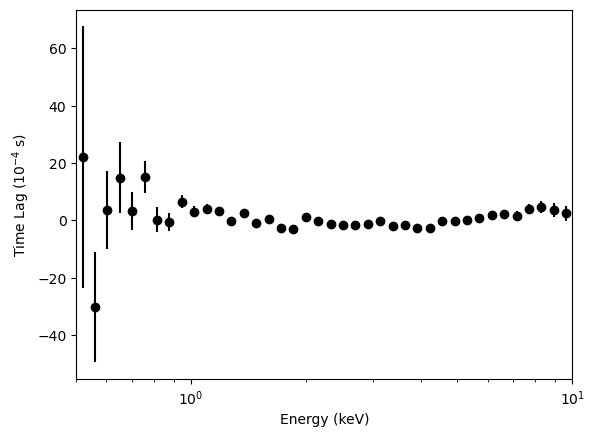

In [41]:
plt.figure()
plt.errorbar(
    energies,
    lagspec_3_30.spectrum * 1e4,
    yerr=lagspec_3_30.spectrum_error * 1e4,
    fmt="o",
    label="3-30 Hz",
    color="k",
)
plt.xlabel("Energy (keV)")
plt.ylabel("Time Lag ($10^{-4}$ s)")
plt.xlim([0.5, 10])
plt.semilogx()

In [42]:
lagspec_01_1 = LagSpectrum(
    ev_filled,
    freq_interval=[0.1, 1],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    ref_band=ref_band,
)
energies = lagspec_01_1.energy
energies_err = np.diff(lagspec_01_1.energy_intervals, axis=1).flatten() / 2

100%|██████████| 40/40 [00:09<00:00,  4.10it/s]


Text(0, 0.5, 'Time lag (s)')

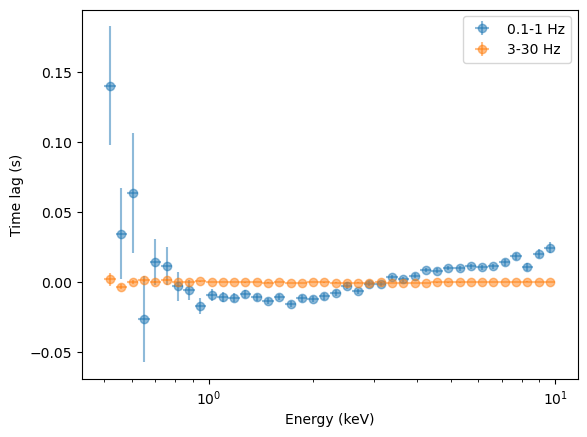

In [43]:
plt.figure()
plt.errorbar(
    energies,
    lagspec_01_1.spectrum,
    xerr=energies_err,
    yerr=lagspec_01_1.spectrum_error,
    fmt="o",
    label="0.1-1 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    lagspec_3_30.spectrum,
    xerr=energies_err,
    yerr=lagspec_3_30.spectrum_error,
    fmt="o",
    label="3-30 Hz",
    alpha=0.5,
)
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Time lag (s)")

Text(0, 0.5, 'Phase lag (rad)')

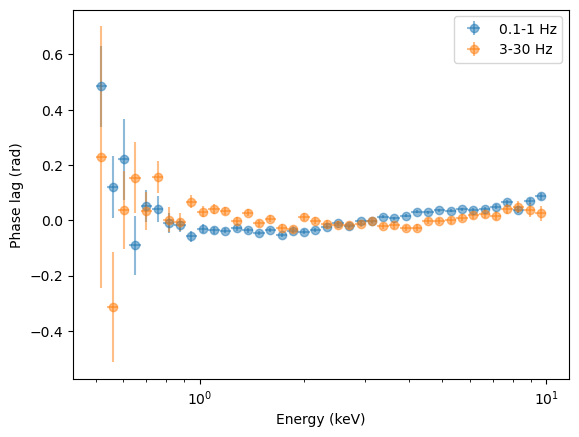

In [44]:
freq_01_1 = (1 + 0.1) / 2 * 2 * np.pi
freq_3_30 = (3 + 30) / 2 * 2 * np.pi
plt.figure()
plt.errorbar(
    energies,
    lagspec_01_1.spectrum * freq_01_1,
    xerr=energies_err,
    yerr=lagspec_01_1.spectrum_error * freq_01_1,
    fmt="o",
    label="0.1-1 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    lagspec_3_30.spectrum * freq_3_30,
    xerr=energies_err,
    yerr=lagspec_3_30.spectrum_error * freq_3_30,
    fmt="o",
    label="3-30 Hz",
    alpha=0.5,
)
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Phase lag (rad)")


## covariance and RMS spectrum

In [45]:
covspec_3_30 = CovarianceSpectrum(
    ev_filled,
    freq_interval=[3, 30],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    norm="abs",
    ref_band=ref_band,
)
covspec_01_1 = CovarianceSpectrum(
    ev_filled,
    freq_interval=[0.1, 1],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    norm="abs",
    ref_band=ref_band,
)

100%|██████████| 40/40 [00:07<00:00,  5.02it/s]


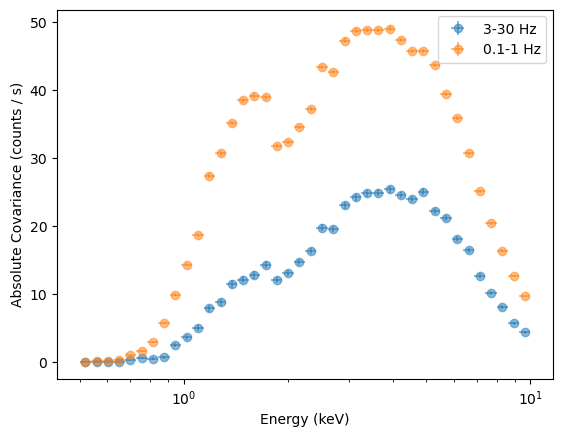

In [46]:
plt.figure()
plt.errorbar(
    energies,
    covspec_3_30.spectrum,
    xerr=energies_err,
    yerr=covspec_3_30.spectrum_error,
    fmt="o",
    label="3-30 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    covspec_01_1.spectrum,
    xerr=energies_err,
    yerr=covspec_01_1.spectrum_error,
    fmt="o",
    label="0.1-1 Hz",
    alpha=0.5,
)
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Absolute Covariance (counts / s)");

In [47]:
countsp = CountSpectrum(ev_filled, energy_spec=energy_spec)

0it [00:00, ?it/s]

40it [00:01, 30.78it/s]


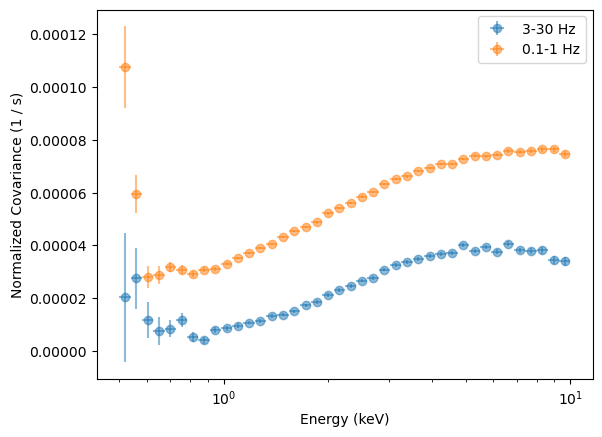

In [48]:
plt.figure()
plt.errorbar(
    energies,
    covspec_3_30.spectrum / countsp.spectrum,
    xerr=energies_err,
    yerr=covspec_3_30.spectrum_error / countsp.spectrum,
    fmt="o",
    label="3-30 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    covspec_01_1.spectrum / countsp.spectrum,
    xerr=energies_err,
    yerr=covspec_01_1.spectrum_error / countsp.spectrum,
    fmt="o",
    label="0.1-1 Hz",
    alpha=0.5,
)
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Normalized Covariance (1 / s)");


In [49]:
#或者，我们可以计算分数均方根归一化的协方差谱

covspec_01_1 = CovarianceSpectrum(
    ev_filled,
    freq_interval=[0.1, 1],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    norm="frac",
)
covspec_3_30 = CovarianceSpectrum(
    ev_filled,
    freq_interval=[3, 30],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    norm="frac",
)


100%|██████████| 40/40 [00:07<00:00,  5.12it/s]


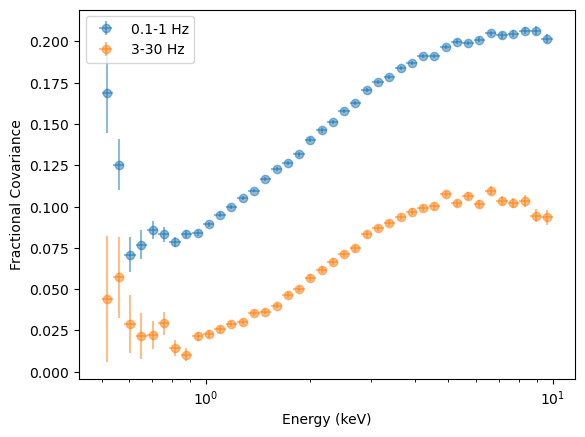

In [50]:

plt.figure()
plt.errorbar(
    energies,
    covspec_01_1.spectrum,
    xerr=energies_err,
    yerr=covspec_01_1.spectrum_error,
    fmt="o",
    label="0.1-1 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    covspec_3_30.spectrum,
    xerr=energies_err,
    yerr=covspec_3_30.spectrum_error,
    fmt="o",
    label="3-30 Hz",
    alpha=0.5,
)
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Fractional Covariance");

In [51]:
rmsspec_01_1 = RmsSpectrum(
    ev_filled,
    freq_interval=[0.1, 1],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    norm="frac",
)
rmsspec_3_30 = RmsSpectrum(
    ev_filled,
    freq_interval=[3, 30],
    segment_size=segment_size,
    bin_time=bin_time,
    energy_spec=energy_spec,
    norm="frac",
)


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:02<00:00, 15.65it/s]


In [52]:
events_sub.time

array([3.67945493e+08, 3.67945493e+08, 3.67945493e+08, ...,
       3.67952513e+08, 3.67952513e+08, 3.67952513e+08], dtype=float64)

In [53]:
bin_time = 20
ps = Powerspectrum.from_events(ev_filled, dt=bin_time, norm="leahy")

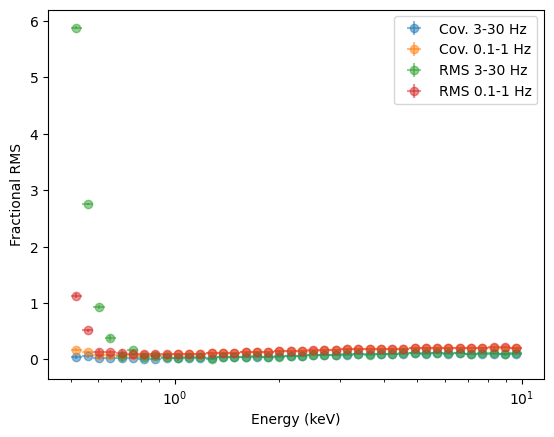

In [54]:
plt.figure()
plt.errorbar(
    energies,
    covspec_3_30.spectrum,
    xerr=energies_err,
    yerr=covspec_3_30.spectrum_error,
    fmt="o",
    label="Cov. 3-30 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    covspec_01_1.spectrum,
    xerr=energies_err,
    yerr=covspec_01_1.spectrum_error,
    fmt="o",
    label="Cov. 0.1-1 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    rmsspec_3_30.spectrum,
    xerr=energies_err,
    yerr=rmsspec_3_30.spectrum_error,
    fmt="o",
    label="RMS 3-30 Hz",
    alpha=0.5,
)
plt.errorbar(
    energies,
    rmsspec_01_1.spectrum,
    xerr=energies_err,
    yerr=rmsspec_01_1.spectrum_error,
    fmt="o",
    label="RMS 0.1-1 Hz",
    alpha=0.5,
)
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Fractional RMS");